In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

In [112]:
import fitsio as fio
import redmapper
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import h5py 
%matplotlib inline
import os.path

sns.set_theme()
sns.set_style("ticks")
sns.set(rc = {'figure.figsize':(12,8)})

In [2]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"

In [3]:
lambda_spt_combined_path="data/lambda_spt_combined.pkl"

In [4]:
df = pd.read_pickle(os.path.join(project_path,lambda_spt_combined_path))

$\langle\Sigma \mid \lambda \operatorname{bin}, \zeta \operatorname{bin}\rangle=\int_{\lambda_{\min }}^{\lambda_{\max }} d \lambda \int_{\zeta_{\min }}^{\zeta \max } d \zeta \Sigma P(\Sigma \mid \lambda, \zeta)$

In [5]:
halo_df = df[(~np.isnan(df['lambda_30']))&(~np.isnan(df['M500c']))]
halo_df = halo_df[halo_df['zeta_gt_2']==1]
print(len(halo_df))

1404


To predict it analytically seems difficult.  We could try Monte Carlo first: 

For a given M500c, draw lnλ and lnζ, $\ln M_{WL}$ (using scaling relation and 3x3 covariance matrix)

<lnλ|M> = A + B lnM, scatter

<lnζ|M> = A + B lnM, scatter

<lnMWL|M> = lnM, scatter

Draw with correlated scatter with lnλ (let's assume scatter=0.1, correlation coefficient r)

Bin λ and ζ and calculate the <MWL|det>, <MWL|no det>, <MWL|all>

Repeat, see how these <MWL> changes with r

In [6]:
from colossus.cosmology import cosmology
h = 0.6726
params = {'flat' : True, 'H0' : 67.26,  'Om0' : 0.14212/h**2, 'Ob0' : 0.02222/h**2, 'sigma8' : 0.81, 'ns' : 9.9652, 'w0' : -1.0, 'Neff' : 3.04}
cosmo = cosmology.setCosmology('Abacus',params)
print(cosmo)
h_70 = cosmo.H0/70

Cosmology "Abacus" 
    flat = True, Om0 = 0.3142, Ode0 = 0.6858, Ob0 = 0.0491, H0 = 67.26, sigma8 = 0.8100, ns = 9.9652
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0400, powerlaw = False


In [7]:
A_SZ = 5.24
B_SZ = 1.534
C_SZ = 0.465
sigma_SZ = 0.161
gamma_f = 1.2
SPT_xi_cut = 4.5

$\langle\ln (\lambda) \mid M\rangle=\ln \lambda_{0}+\mathrm{A}_{\lambda} \ln \left(\mathrm{M} / \mathrm{M}_{\mathrm{piv}}\right)+\mathrm{B}_{\lambda} \ln ((1+\mathrm{z}) / 1.45)$

In [19]:
A_lambda = 0.939
B_lambda = 0.32
ln_lambda_0 = 4.25
sig_intrinsic = 0.1
sig_sz = 0.161
sig_M_wl = 0.1

r = 0.1

def get_mean_lambda(M,z,A_lambda_,B_lambda_,ln_lambda_0_):
    return(ln_lambda_0_+A_lambda_*np.log(M*h/5E14)+B_lambda_*np.log((1+z)/1.45))

def get_sig_lambda(sig_intrinsic_,mean_lambda_):
    return(np.sqrt(sig_intrinsic**2 + (np.exp(mean_lambda_)-1)/np.exp(2*mean_lambda_)))

def get_mean_M_wl(M500c):
    return(np.log(M500c))

def get_mean_zeta(M500c, z, A_SZ_,B_SZ_,C_SZ_):
    log_zeta = np.log(A_SZ_) + B_SZ_*np.log((M500c*h_70)/(4.3E14)) + C_SZ_*np.log(cosmo.Ez(z)/cosmo.Ez(0.6))
    return log_zeta

In [20]:
from scipy.stats import multivariate_normal
M500c_array = halo_df['M500c'].to_numpy()
z_array = halo_df['z'].to_numpy()

In [21]:
def get_cov_matrix(M500c,z,r_):
    mean_lambda = get_mean_lambda(M500c, z, A_lambda, B_lambda, ln_lambda_0)
    sig_lambda = get_sig_lambda(sig_intrinsic, mean_lambda)
    cov_matrix = np.array([
                          [sig_lambda**2,         r_*sig_M_wl*sig_lambda, 0],
                          [r_*sig_M_wl*sig_lambda, sig_M_wl**2,                  0],
                          [0,                     0,             sig_sz**2]
                          ])
    return(cov_matrix)

In [22]:
def get_mean(M500c,z):
    mean_lambda = get_mean_lambda(M500c, z, A_lambda, B_lambda, ln_lambda_0)
    mean_M_wl = get_mean_M_wl(M500c)
    mean_zeta = get_mean_zeta(M500c, z, A_SZ, B_SZ, C_SZ)
    return(mean_lambda, mean_M_wl, mean_zeta)

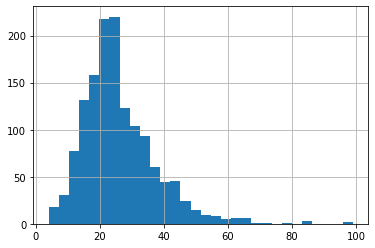

In [33]:
halo_df['lambda_30'].hist(bins=30)

Text(0.5, 1.0, 'Histogram of richness')

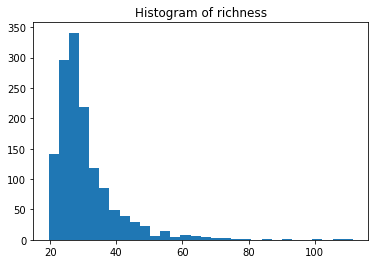

In [34]:
test = get_mean(M500c_array,0.3)
plt.hist(np.exp(test[0]),bins=30)
plt.title("Histogram of richness")

(array([ 28.,  58., 109., 119., 180., 191., 142., 128.,  86.,  77.,  55.,
         56.,  32.,  30.,  24.,  22.,  12.,  13.,   6.,   7.,   8.,   6.,
          3.,   3.,   1.,   2.,   2.,   0.,   1.,   3.]),
 array([14.295039 , 14.321944 , 14.348849 , 14.375755 , 14.40266  ,
        14.429565 , 14.4564705, 14.483376 , 14.510282 , 14.537187 ,
        14.564092 , 14.590997 , 14.617902 , 14.644808 , 14.671713 ,
        14.698618 , 14.725523 , 14.752428 , 14.779334 , 14.806239 ,
        14.833144 , 14.860049 , 14.886954 , 14.91386  , 14.940765 ,
        14.96767  , 14.9945755, 15.021481 , 15.048387 , 15.075292 ,
        15.102197 ], dtype=float32),
 <a list of 30 Patch objects>)

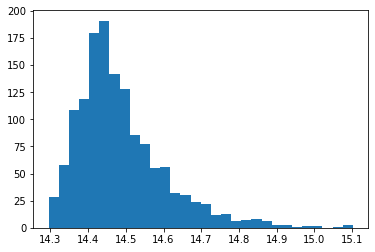

In [32]:
plt.hist(np.log10(M500c_array),bins=30)

In [116]:
def get_MC_for_r(r):
    richness_array = np.empty(len(halo_df))
    M_wl_array = np.empty(len(halo_df))
    zeta_array = np.empty(len(halo_df))
    for i in range(len(halo_df)):    
        ln_richness, ln_M_wl, ln_zeta = multivariate_normal.rvs(mean=get_mean(M500c_array[i],z_array[i]),
                                    cov=get_cov_matrix(M500c_array[i], z_array[i]))
        richness_array[i] = np.exp(ln_richness)
        M_wl_array[i] = np.exp(ln_M_wl)
        zeta_array[i] = np.exp(ln_zeta)

    halo_df[f'MC_richness_{r}'] = richness_array
    halo_df[f'MC_M_wl_{r}'] = M_wl_array
    halo_df[f'MC_zeta_{r}'] = zeta_array

In [152]:
r_bins = np.linspace(0,1,5)
print(r_bins)
for r in r_bins:
    get_MC_for_r(r)

[0.   0.25 0.5  0.75 1.  ]


In [153]:
richness_bins = [0,20,30,45,60,np.inf]

In [154]:
halo_df['MC_richness_bin'], richness_bins  = pd.cut(halo_df['MC_richness'],richness_bins,
                                                   retbins=True)

In [155]:
halo_df.columns

Index(['R_lambda_60', 'lambda_60', 'R_lambda_30_noperc', 'lambda_30_noperc',
       'R_lambda_30', 'lambda_30', 'R_lambda_15', 'lambda_15', 'R_lambda_1',
       'lambda_1', 'parent_id', 'M500c', 'M200b', 'z', 'pos_x', 'pos_y',
       'pos_z', 'mean_ln_zeta', 'mean_ln_lambda', 'zeta', 'xi', 'xi_gt_45',
       'xi_gt_5', 'zeta_gt_2', 'select', 'MC_richness', 'MC_M_wl', 'MC_zeta',
       'MC_richness_bin', 'MC_richness_0.0', 'MC_M_wl_0.0', 'MC_zeta_0.0',
       'MC_richness_0.25', 'MC_M_wl_0.25', 'MC_zeta_0.25', 'MC_richness_0.5',
       'MC_M_wl_0.5', 'MC_zeta_0.5', 'MC_richness_0.75', 'MC_M_wl_0.75',
       'MC_zeta_0.75', 'MC_richness_1.0', 'MC_M_wl_1.0', 'MC_zeta_1.0',
       'MC_richness_1.25', 'MC_M_wl_1.25', 'MC_zeta_1.25', 'MC_richness_2.5',
       'MC_M_wl_2.5', 'MC_zeta_2.5', 'MC_richness_3.75', 'MC_M_wl_3.75',
       'MC_zeta_3.75', 'MC_richness_5.0', 'MC_M_wl_5.0', 'MC_zeta_5.0'],
      dtype='object')

In [156]:
sns.set_style('ticks')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


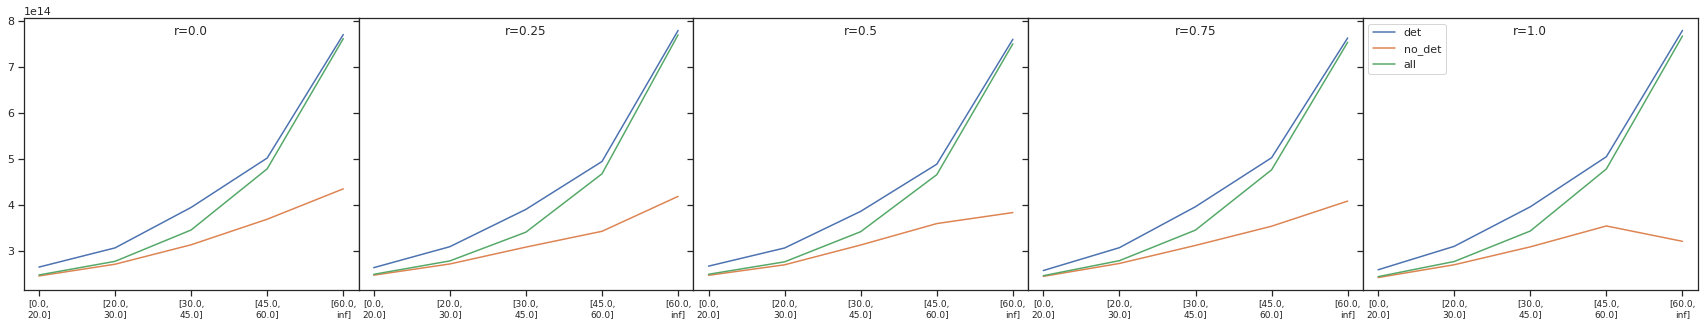

In [166]:
SPT_mask = halo_df['select'] == 1

fig, axes = plt.subplots(ncols=5,figsize=[30,5],sharey=True)

def plot_M_wl(ax, M_wl_det, M_wl_no_det, M_wl_all, r):
    ax.plot(range(5),M_wl_det,label="det")
    ax.plot(range(5),M_wl_no_det,label="no_det")
    ax.plot(range(5),M_wl_all,label="all")
    plt.legend()
    locs, labels = plt.xticks()
    xticks = (np.arange(0,5,5), ["1"])
    ax.set_xticks(range(5))
    ax.set_xticklabels([f"[{richness_bins[i]},\n{richness_bins[i+1]}]" for i in range(5)])
    ax.text(0.5, 0.95, rf'r={r}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.tick_params(axis='x', labelsize=9)


for i,r in enumerate(r_bins):
    
    M_wl_det = halo_df[SPT_mask].groupby(halo_df[SPT_mask]['MC_richness_bin']).mean()[f'MC_M_wl_{r}']
    M_wl_no_det = halo_df[~SPT_mask].groupby(halo_df[~SPT_mask]['MC_richness_bin']).mean()[f'MC_M_wl_{r}']
    M_wl_all = halo_df.groupby(halo_df['MC_richness_bin']).mean()[f'MC_M_wl_{r}']
    
    plot_M_wl(axes[i],M_wl_det, M_wl_no_det, M_wl_all, r)
plt.subplots_adjust(wspace=0)

In [141]:
richness_bins 

array([ 0., 20., 30., 45., 60., inf])